# Dados e Aprendizagem Automática, MEI/MIEInf, UMinho 2022/23

In [1]:
import numpy
import pandas
import seaborn
from dateutil import parser 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

c:\Users\Utilizador\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Descrição do Dataset

De modo a se poder aplicar corretamente um modelo de machine learning é necessário primeiro analisar e limpar o dataset que nos foi providenciado pelos docentes da disciplina. Este dataset contém dados relativos à intensidade de incidentes na em Guimarães durante um certo período de tempo. Os atributos que podemos encontrar são:

* magnitude_of_delay
* delay_in_seconds
* affected_roads
* record_date
* luminosity
* avg_temperature
* avg_atm_pressure
* avg_humidity
* avg_wind_speed
* avg_precipitation
* avg_rain
* incidents


### Objetivo

Feita uma análise ao dataset pode-se concluir que o atributo que é necessário utilizar para que o modelo seja capaz de prever a intensidade de acidentes de transito é o **incidents**.

## Processamento de dados


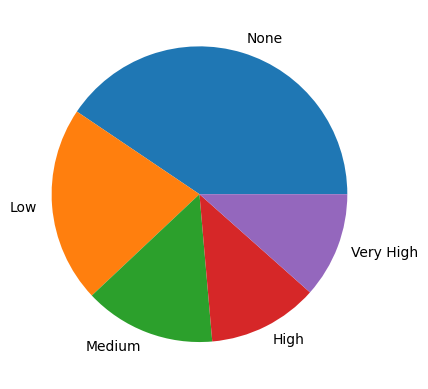

Percentual Distribution of incidents
None         40.56
High         21.46
Low          14.36
Very High    12.06
Medium       11.56
Name: incidents, dtype: float64


In [2]:
data = pandas.read_csv('../../Datasets/Incidents/training_data.csv', encoding='iso-8859-1', keep_default_na=False)
test = pandas.read_csv('../../Datasets/Incidents/test_data.csv', encoding='iso-8859-1', keep_default_na=False)

data.columns = data.columns.str.lower()
test.columns = test.columns.str.lower()

data['incidents'] = data['incidents'].map({'None':0, 'Low':1, 'Medium':2, 'High':3, 'Very_High':4})

pd = data['incidents'].value_counts(normalize=True) * 100
labels = ['None', 'Low', 'Medium', 'High', 'Very High']

plt.pie(pd, labels=labels)
plt.show()

print("Percentual Distribution of incidents")
pd.index = pd.index.map({0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
print(pd)

## Análise do *incidents*

Como se pode observar no gráfico anterior, o atributo é composto pelos parâmetros **None**, **Low**, **Medium**, **High** e **Very_High** que definem a intensidade de incidentes. Estes parâmetros constituem a escala que será utilizada nas previsões.
    
Através do gráfico pode-se elaborar uma ideia dos incidentes que acontecem ao longo do dia. Por exemplo, a maior percentagem corresponde a **None**, cerca de 40%. Com isto, pode-se concluir que existem bastantes períodos do dia em que não existe qualquer tipo de incidente. Já no caso do **Very_High**, com percentagem de 12%, conclui-se que é referente a períodos do dia como no inicio da manhã e o final de tarde nos quais existe uma intensidade de trânsito mais elevada e uma probabilidade maior de incidentes.


## Análise de *record_date*

Dividir a *record_date* de forma a conseguir analisar de melhor forma os dados obtidos e conseguir prever com melhor precisão a intensidade do de acidentes de transito


In [3]:
data['record_date'] = data.record_date.map(lambda x : parser.parse(x))
data['week_day'] = data.record_date.map(lambda x : x.weekday())
data['month'] = data.record_date.map(lambda x : x.month)
data['hour'] = data.record_date.map(lambda x : x.hour)

test['record_date'] = test.record_date.map(lambda x : parser.parse(x))
test['week_day'] = test.record_date.map(lambda x : x.weekday())
test['month'] = test.record_date.map(lambda x : x.month)
test['hour'] = test.record_date.map(lambda x : x.hour)

## Missing Values

Missing values são uns dos problemas mais comuns que se pode encontrar durante a fase da preparação de dataset. Um dos motivos para isto acontecer, é por exemplo, o erro humano, ou questões de privacidade, entre outros. Independentemente da razão, estes missing values afetam o desempenho dos modelos. Pode-se verificar que existiam valores em falta no atributo "avg_precipitation". Para além disto, valores como ',', muito presentes no atributo "affected_roads", também foram considerados como *missing values*. 


In [4]:
data = (data[data['affected_roads'] != ","])
test = (data[data['affected_roads'] != ","])

data.drop(['avg_precipitation'], inplace=True, axis=1)
test.drop(['avg_precipitation'], inplace=True, axis=1)

## Análise de Luminosity

A luminosidade é um fator que afeta a segurança de condução e, por consequência, a velocidade máxima aconselhada. Desta forma foi considerado que este atributo deveria ser incluído no modelo que irá ser criado. Para se poder utilizar os valores deste atributo foi aplicado um map que troca os valores {'DARK', 'LOW_LIGHT', 'LIGHT'} por {0, 1, 2}, respetivamente.

In [5]:
data['luminosity'] = data['luminosity'].map({'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2})

test['luminosity'] = test['luminosity'].map({'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2})


## Categorical Vars

Transformar todas as variáveis categóricas em valores inteiros de forma a conseguir prever a variável alvo.


In [6]:
data['avg_rain'] = data['avg_rain'].map({'Sem Chuva': 0, 'chuva fraca': 1, 'chuva moderada': 2, 'chuva forte': 2})

data['magnitude_of_delay'] = data['magnitude_of_delay'].map({'UNDEFINED': 0, 'MAJOR': 1})

test['avg_rain'] = test['avg_rain'].map({'Sem Chuva': 0, 'chuva fraca': 1, 'chuva moderada': 2, 'chuva forte': 2})

test['magnitude_of_delay'] = test['magnitude_of_delay'].map({'UNDEFINED': 0, 'MAJOR': 1})

data_train = data.dropna()

affected_roads_list = data_train.affected_roads.str.split(",").map(lambda x: list(set(x)))

data_train = data_train.assign(affected_roads=affected_roads_list).explode('affected_roads')
data_train = (data_train[data_train['affected_roads'] != ""])

data_train['affected_roads'] = pandas.CategoricalIndex(data_train['affected_roads'])
data_train['affected_roads'] = data_train['affected_roads'].cat.codes

data_train = data_train.reset_index()

data_test = test.dropna()

affected_roads_list = data_test.affected_roads.str.split(",").map(lambda x: list(set(x)))

data_test = data_test.assign(affected_roads=affected_roads_list).explode('affected_roads')
data_test = (data_test[data_test['affected_roads'] != ""])

data_test['affected_roads'] = pandas.CategoricalIndex(data_test['affected_roads'])
data_test['affected_roads'] = data_test['affected_roads'].cat.codes

data_test = data_test.reset_index()

<AxesSubplot:xlabel='incidents', ylabel='delay_in_seconds'>

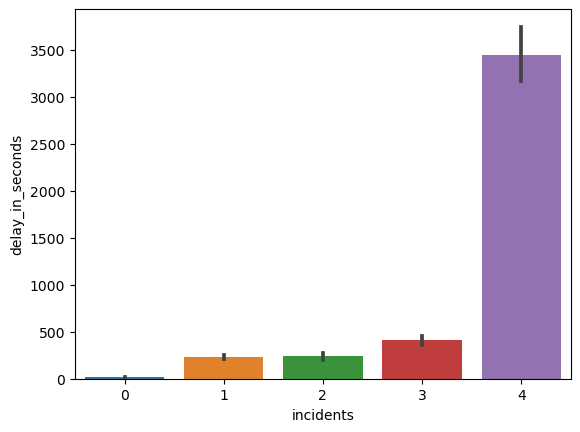

In [7]:
seaborn.barplot(x='incidents', y='delay_in_seconds', data=data)

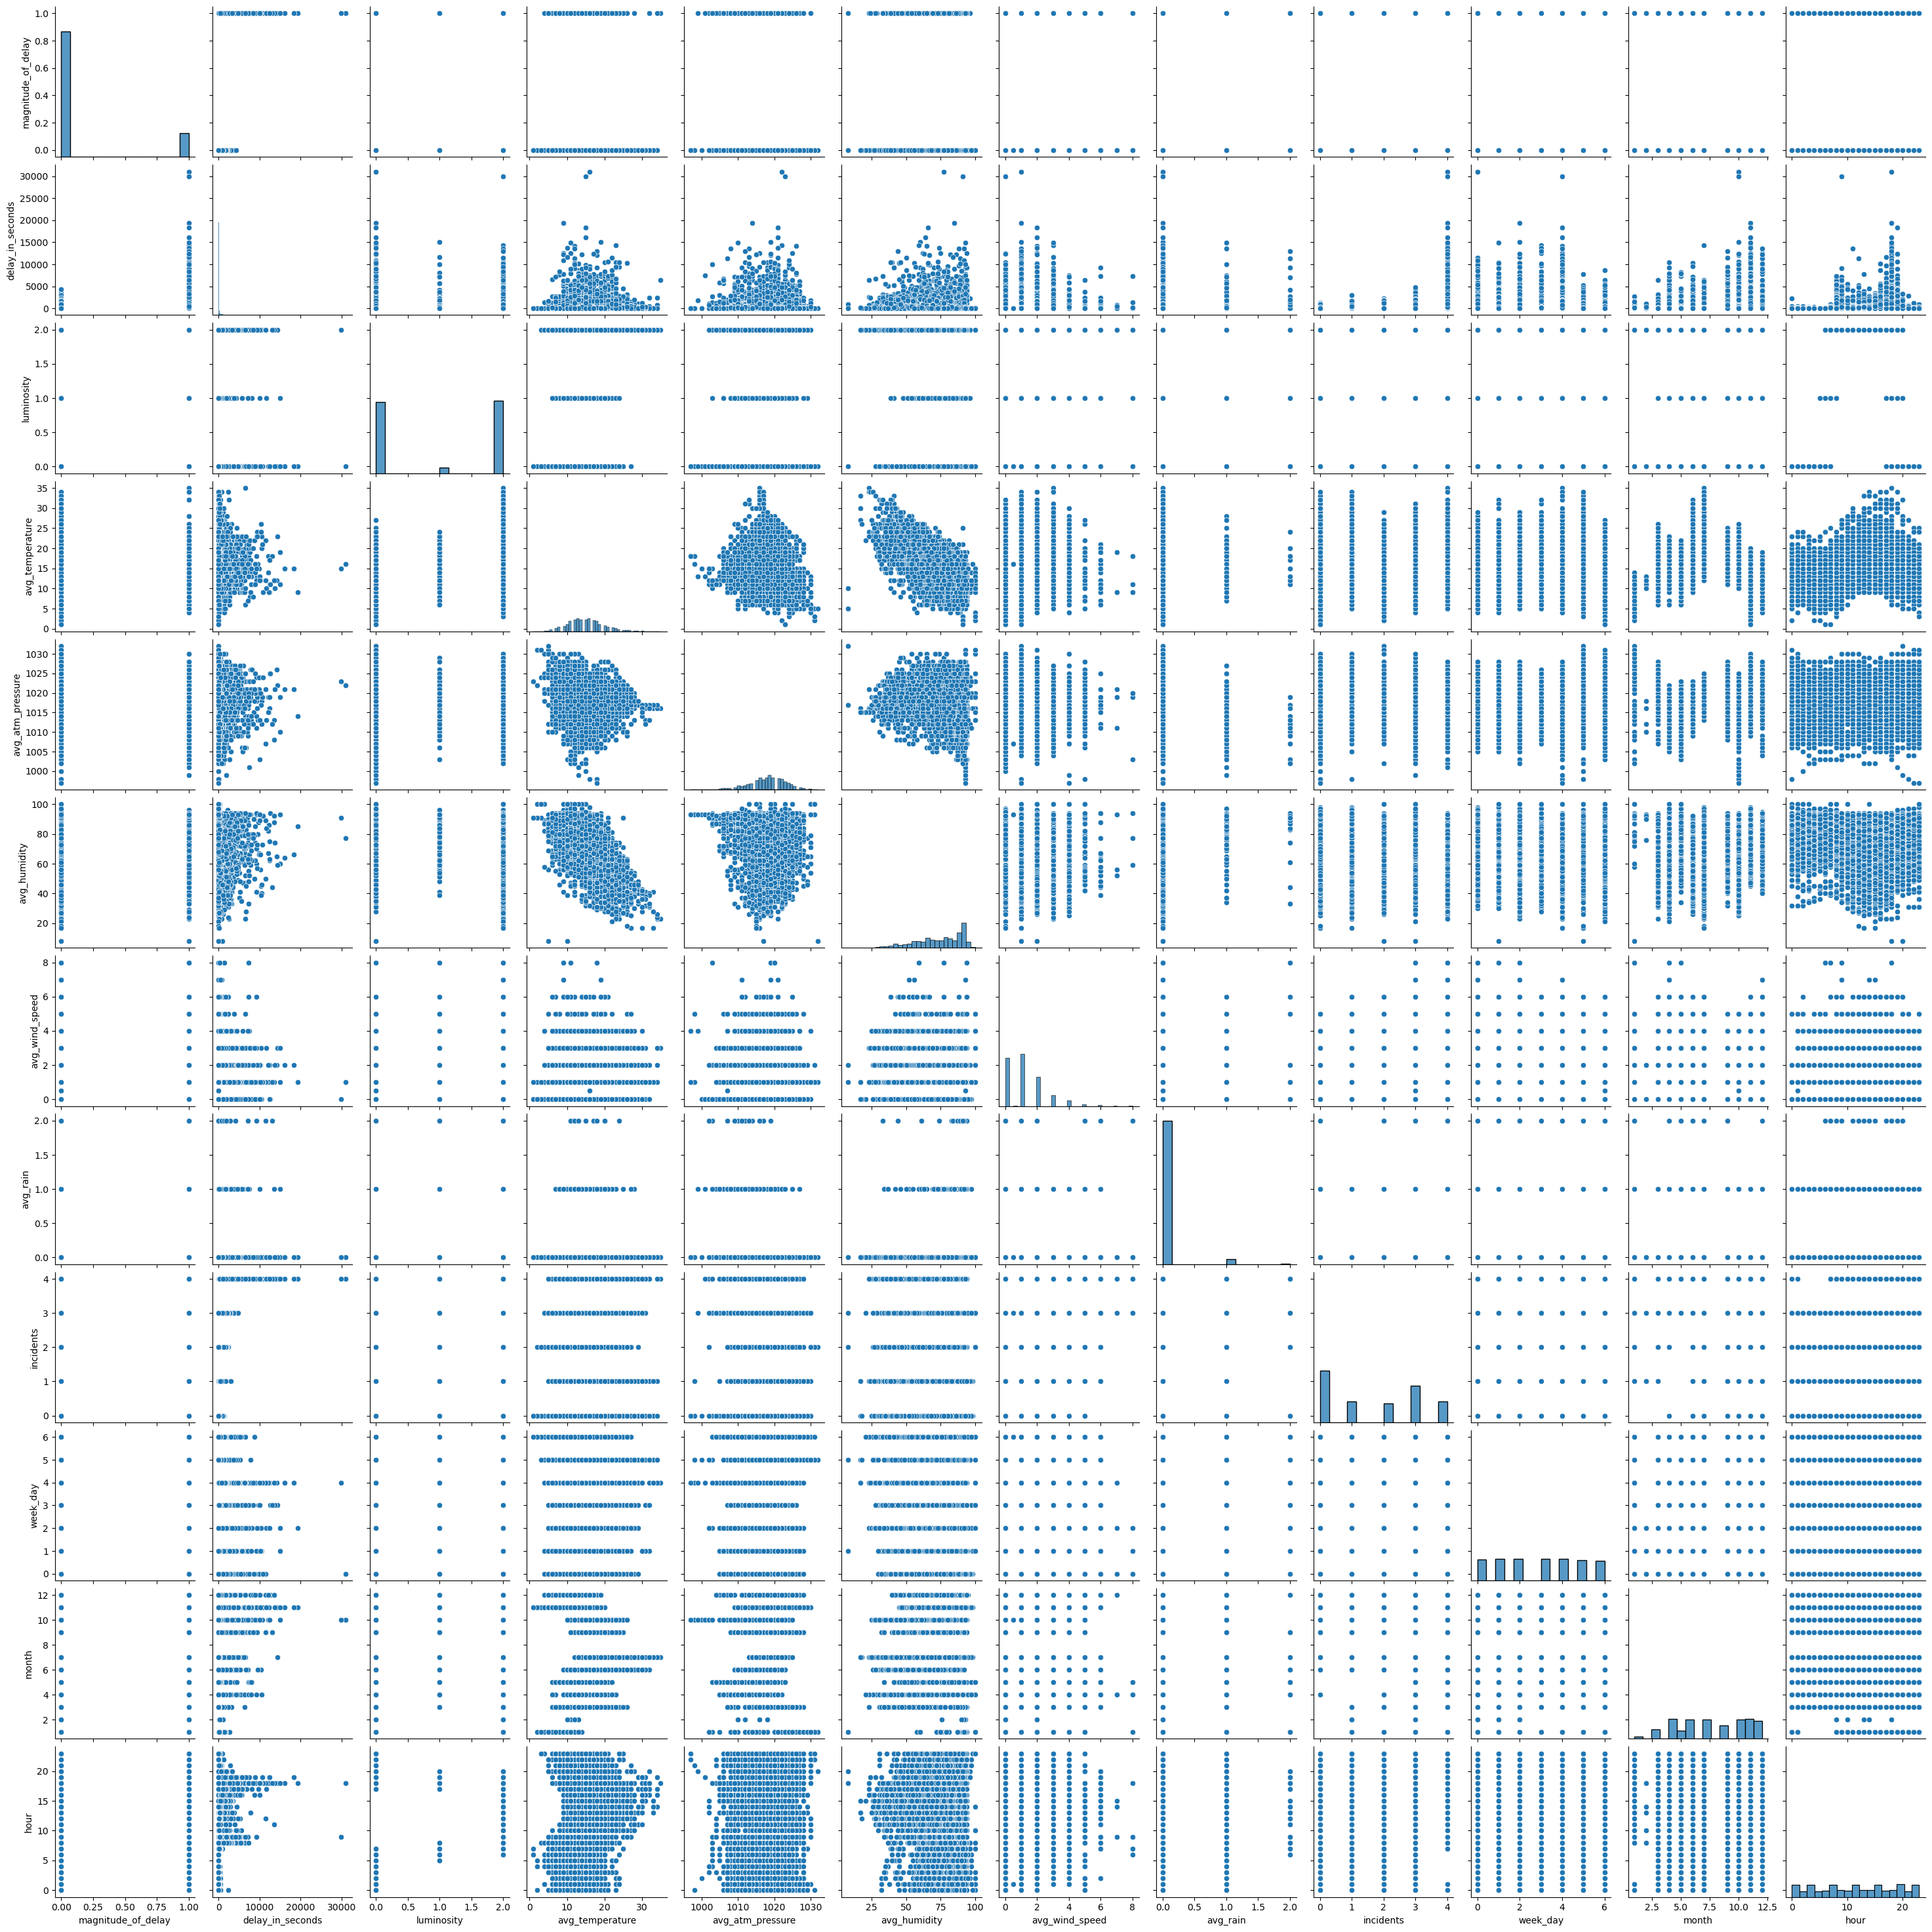

In [8]:
seaborn.pairplot(data)

<AxesSubplot:>

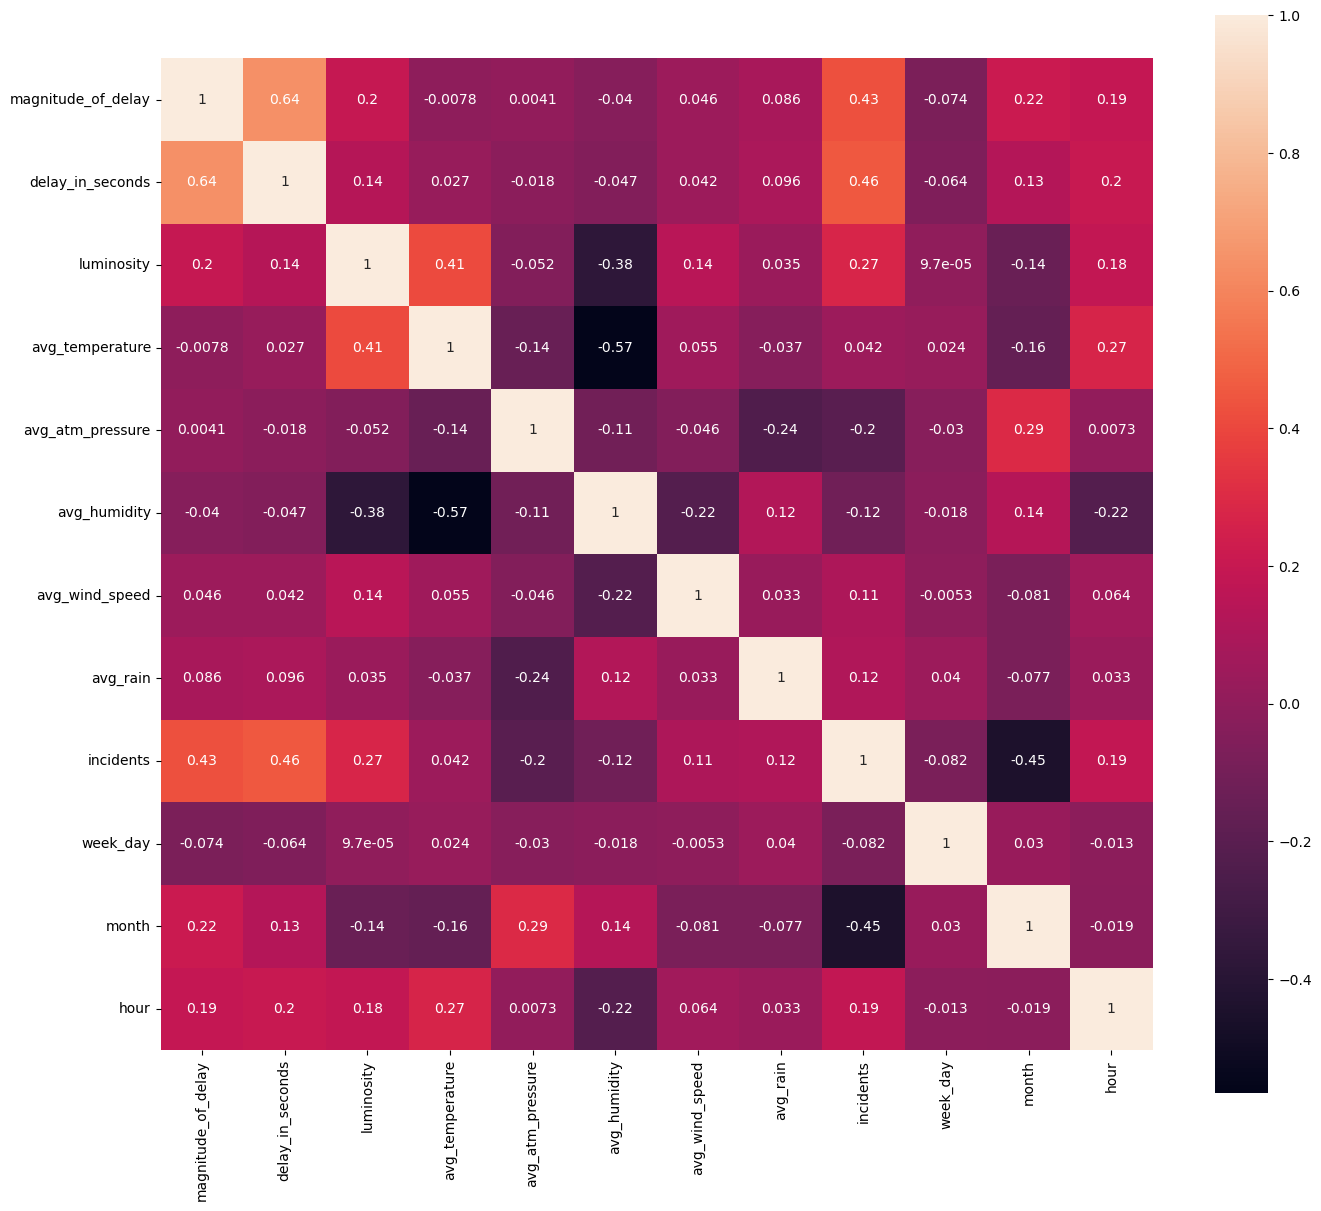

In [9]:
correl = data.corr()
f,ax = plt.subplots(figsize=(16,14))
seaborn.heatmap(correl,vmax=1,square=True,annot=True)

In [10]:
data_train = data_train.drop(['city_name'], axis=1)
data_train = data_train.drop(['record_date'], axis=1)
train = data_train.drop(['index'], axis=1)

train

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,week_day,month,hour
0,0.0,385,3,0,12.0,1007.0,91.0,1.0,0,0,5,12,18
1,1.0,2297,4,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
2,1.0,2297,3,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
3,1.0,2297,9,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
4,0.0,0,3,2,27.0,1020.0,52.0,1.0,0,3,6,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,0.0,0,3,0,17.0,1020.0,67.0,2.0,0,2,2,6,22
5541,0.0,0,3,0,13.0,1021.0,56.0,0.0,0,3,1,4,0
5542,0.0,0,3,2,19.0,1017.0,68.0,0.0,0,0,1,7,14
5543,0.0,0,3,0,12.0,1014.0,93.0,2.0,0,0,1,11,6


In [11]:
data_test = data_test.drop(['city_name'], axis=1)
data_test = data_test.drop(['record_date'], axis=1)
tests = data_test.drop(['index'], axis=1)

tests

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,week_day,month,hour
0,0.0,385,3,0,12.0,1007.0,91.0,1.0,0,0,5,12,18
1,1.0,2297,4,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
2,1.0,2297,3,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
3,1.0,2297,9,2,15.0,1028.0,75.0,1.0,0,4,2,9,9
4,0.0,0,3,2,27.0,1020.0,52.0,1.0,0,3,6,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,0.0,0,3,0,17.0,1020.0,67.0,2.0,0,2,2,6,22
5541,0.0,0,3,0,13.0,1021.0,56.0,0.0,0,3,1,4,0
5542,0.0,0,3,2,19.0,1017.0,68.0,0.0,0,0,1,7,14
5543,0.0,0,3,0,12.0,1014.0,93.0,2.0,0,0,1,11,6


In [12]:
model_xgb = xgb.XGBRFRegressor(n_estimators=2500, max_depth=7, learning_rate=0.01, subsample=0.7, colsample_bytree=0.8)
model_gradBoosting = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, subsample=0.5)

In [13]:
model_xgb.fit(train,train['incidents'])
model_gradBoosting.fit(train,train['incidents'])

c:\Users\Utilizador\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000,
                          subsample=0.5)

In [14]:
xg_test = model_gradBoosting.predict(tests)
gb_test = model_gradBoosting.predict(tests)

In [15]:
predictions = (xg_test + gb_test) / float (2)

pred = numpy.ndarray.round(predictions)
pred[pred==0.] = 0

pred = numpy.where(pred ==0, "None", pred)
pred = numpy.where(pred =="1.0", "Low", pred)
pred = numpy.where(pred =="2.0", "Medium", pred)
pred = numpy.where(pred == "3.0", "High", pred)
pred = numpy.where(pred =="4.0", "Very_High", pred)

pandas.DataFrame({"incidents": pred}).to_csv(f'../../Predictions/Incidents/prediction.csv',index=True)